<hr style="border-width:4px; border-color:coral; border-style:solid" /hr>

# Using  `timeit`
<hr style="border-width:4px; border-color:coral; border-style:solid" /hr>

The Python `timeit` command can be used to time short snippets of code in a Jupyter notebook. 
The `timeit` command comes in both "magic" commands  and a module function.  

This notebook describes three ways to use `timeit`.  

* Using `%timeit` in <a href="#cellmode">cell mode</a>
* Using `%timeit` in <a href="#linemode">line mode</a>
* Using the `timeit` <a href="#module">module</a>

This notebook also gives you a more detailed description of what `timeit` does under the hood <a href="#loops">here</a>, and an interactive plot illustrating the effects of the choice of `timeit` parameters <a href="#plot">here</a>.

You can read more on `timeit` by navigating to these links:

* [iPython documentation to Magic commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit)

* [Python documentation for timeit module](https://docs.python.org/3/library/timeit.html)

In [1]:
%matplotlib notebook
from numpy import *
from matplotlib.pyplot import *

## Sample code to time

To use timeit, we will compute the time it takes to compute the angle between two vectors, using the formula

\begin{equation}
\theta = \cos^{-1}\left(\frac{\mathbf u \cdot \mathbf v}{\parallel \mathbf u \!\parallel \parallel \! \mathbf v \parallel}\right)
\end{equation}

In [2]:
def compute_angle(u,v):
    th = math.acos(sum(u*v)/(norm(u,2)*norm(v,2)))
    return th

Here is a sample call to the above function.

In [3]:
from numpy.random import rand
from numpy.linalg import norm
M = 2**24  
print("{:>20s} {:12.2f}".format('Memory (MB)',8.0*M/(1024**2)))

u = rand(M)
v = rand(M)
th = compute_angle(u,v)
print("{:>20s} {:12.8f}".format('Angle (radians)',th))

         Memory (MB)       128.00
     Angle (radians)   0.72275583


<a id="cellmode"></a>
<hr style="border-width:4px; border-color:coral" /hr>

## Using `%timeit` magic in cell mode
<hr style="border-width:4px; border-color:coral" /hr>

To use `timeit` in cell mode, put the `%%timeit` statement in the top line of the cell.  This will time all commands (after the first line) in a single notebook cell.

In [4]:
%%timeit

th = compute_angle(u,v)

63.7 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


If we put three calls to `compute_angle` in the cell, we see that the time increase by a factor of three. 

In [5]:
%%timeit

th = compute_angle(u,v)
th = compute_angle(u,v)
th = compute_angle(u,v)

169 ms ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In the above, `timeit` reports the average time plus/minus a standard deviation.  The average is taken over the number of runs.  Each run consists of a number of loops. 

The units reported by `timeit` are 

* microseconds ($\mu$s), or $10^{-6}$ seconds

* milliseconds (ms), or $10^{-3}$ seconds.

* seconds (s).

The above call to `timeit` chooses values for number of loops and runs to make. We can pass arguments to `timeit` to set these values explicitly.

In [6]:
%%timeit -r 15 -n 5   # 15 runs of 5 loops each

th = compute_angle(u,v)

54 ms ± 1.19 ms per loop (mean ± std. dev. of 15 runs, 5 loops each)


We can store results by passing `-o` as a parameter, and inspecting the default return result `_`.

In [7]:
%%timeit -r 15 -n 5 -o  # Store results in `_` by using -o

th = compute_angle(u,v)

59.8 ms ± 5.76 ms per loop (mean ± std. dev. of 15 runs, 5 loops each)


<TimeitResult : 59.8 ms ± 5.76 ms per loop (mean ± std. dev. of 15 runs, 5 loops each)>

In [8]:
results = _    # Default return from %%timeit

# Return is a 'TimeitResult' object.  Fields depend on which version of Python you are 
# running.

# We have to divide by 'n' to get time average time for each run.
t = array(results.all_runs)/5*1000

# Get some statistics
m = mean(t)         
s = std(t)          
b = results.best*1000    # Minimum time

print("{:>20s} {:.4f}".format("Best time (ms)",m))
print("{:>20s} {:.4f}".format("Std. dev. time (ms)",s))
print("{:>20s} {:.4f}".format("Average time (ms)",b))

      Best time (ms) 59.8310
 Std. dev. time (ms) 5.7623
   Average time (ms) 52.7673


Using cell mode is the easiest way to call `timeit`.  The main advantage of this form is that we can time several statements in a notebook cell quite easily.  But the main disadvantage is that the return is in the default variable `_`, which is easy to inadvertently overwrite.

<a id="linemode"></a>
<hr style="border-width:4px; border-color:coral" /hr>

## Using `%timeit` in line mode
<hr style="border-width:4px; border-color:coral" /hr>

Using `%timeit` in line mode, we can get the timing statistics returned in a named variable, which we can save for plotting, comparison with other methods, and so on.  

In this version of the command, we pass the statement we wish to time directly to the `'%timeit` magic command.  This call can be anywhere in the notebook cell (not only at the top). 

The return argument is of type `TimeitResult`.  Depending on your Python version, you can access the following fields in an instance of `TimeitResult`:

    # Anaconda Python version 3.5.4 (Red Hat)
    TimeitResult.all_runs          # Array of total times for each of 'r' outer loops
    TimeitResult.best              # Minimum average time of 'n' inner loops
    TimeitResult.compile_time
    TimeitResult.loops             # 'n'  inner loops
    TimeitResult.repeat            # 'r'  outer loops
    TimeitResult.worst             # Maximum average time of 'n' inner loops

Python 3.7.4 includes additional fields `average`, `stdev` and `timings`.   Whereas the `all_runs` field returns the *total* time for each of the `r` outer repeats over `n` inner loops, the `timings` returns the average time over `n` loops.  That is

     results.timings = results.all_runs/results.loops


In [9]:
# Time results using an explicit call to `timeit`. 
# Note the additional `-o` parameter, needed to get results returned.
results = %timeit -r 15 -n 5 -o th = compute_angle(u,v)

# Get some statistics
b = results.best*1000    # Minimum time

print("{:>20s} {:.4f}".format("Best time (ms)",b))

56.5 ms ± 659 µs per loop (mean ± std. dev. of 15 runs, 5 loops each)
      Best time (ms) 55.5558


We can plot the timing results from all runs and get a sense of the variability of the timings on the particular machine we are on. 

<IPython.core.display.Javascript object>


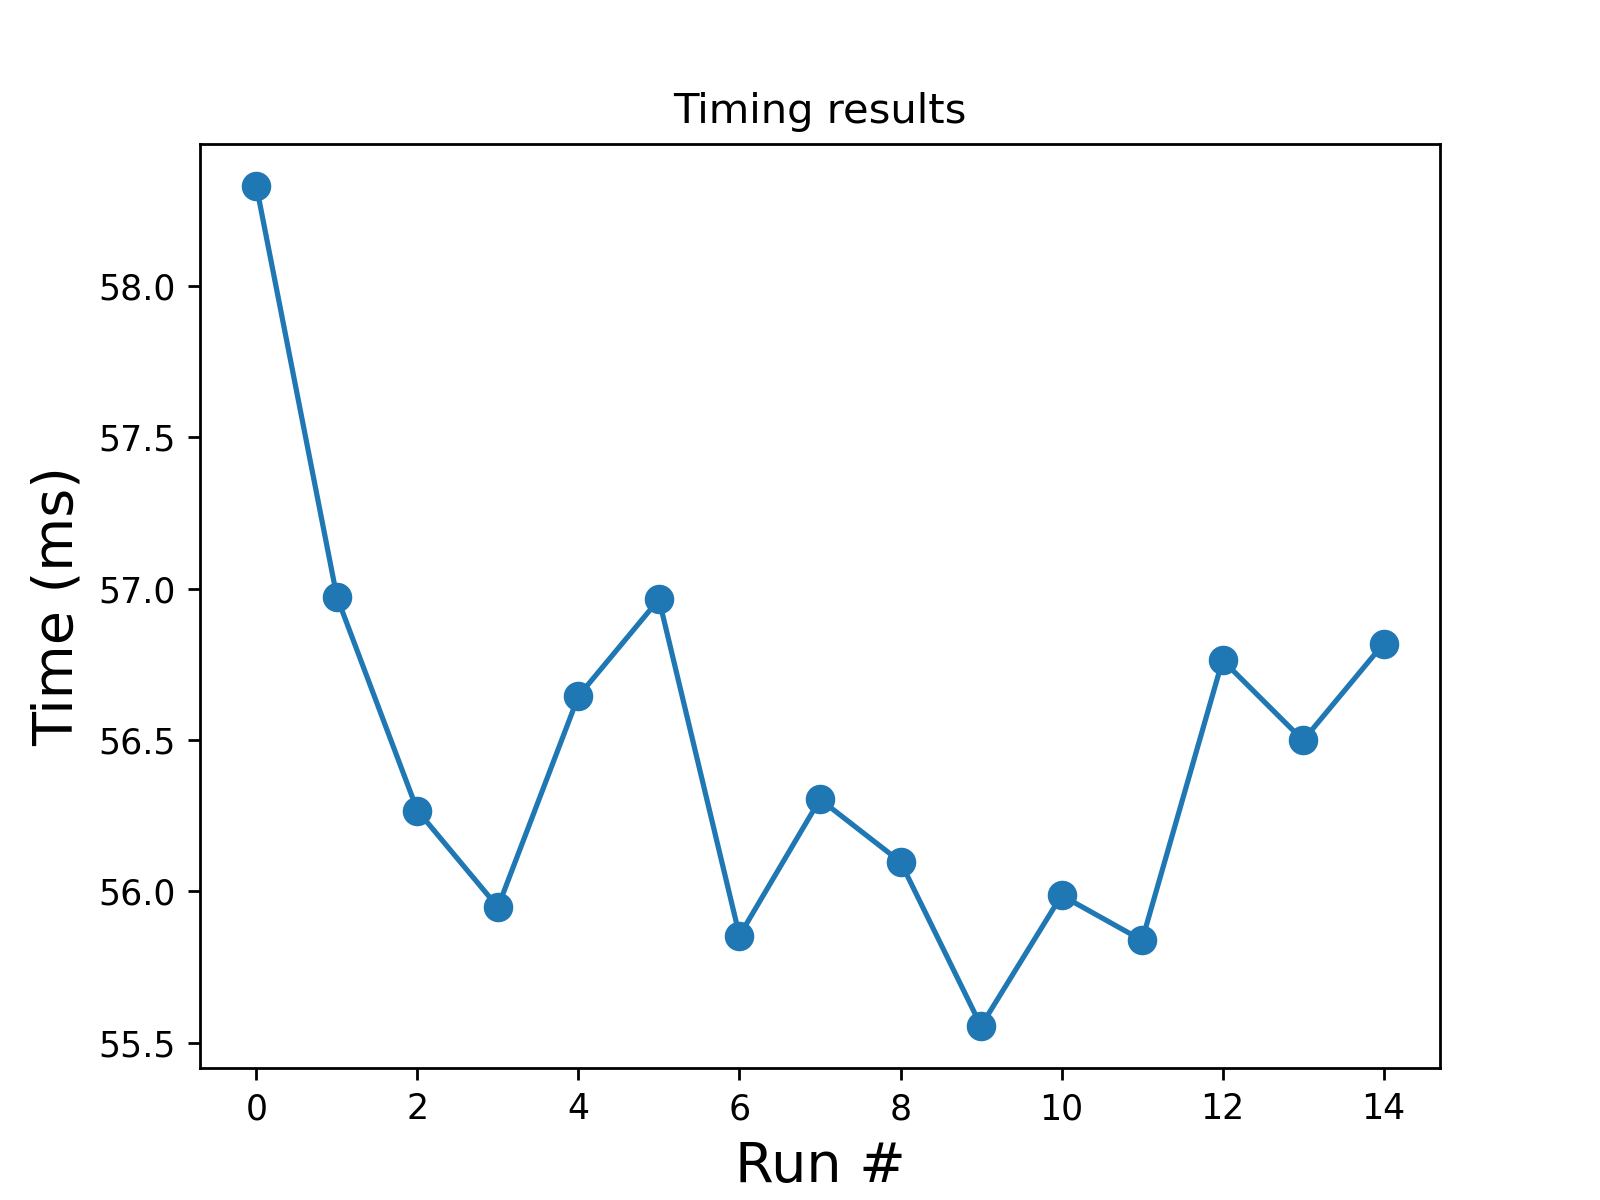

In [10]:
figure(1)
clf()

# Timing results from above;  Divide by n to get average value from the n-loop.
t = array(results.all_runs)/results.loops*1000

plot(t,'.-',markersize=15)    # Convert to milliseconds
title('Timing results')
xlabel('Run #',fontsize=16)
ylabel('Time (ms)',fontsize=16);

<a id="module"></a>
<hr style="border-width:4px; border-color:coral" /hr>

## Use the `timeit` module
<hr style="border-width:4px; border-color:coral" /hr>

The `timeit` module gives us a functional interface for timing single lines of code.  One advantage of this is that we can pass in a variable number of loops `n` and repeats `r`. Below, we show how to use this functional form.

An optional `setup` argument can be used to set up the code to be timed.   This `setup` argument will not be timed.

The optional argument `globals=globals()` will run the command in the global namespace.  

In [11]:
import timeit

r = 15       # Number of runs
n = 5        # Number of loops in each run

def setup_vectors():
    M = 2**24
    v1 = rand(M)
    v2 = rand(M)
    return v1,v2

T = timeit.repeat(stmt='compute_angle(v1,v2)', \
                  setup = 'v1, v2 = setup_vectors()', \
                  repeat = r, \
                  number = n, \
                  globals=globals())

T = array(T)/n      # Convert to NumPy array; divide by n to get average over n loops
b = min(T)*1000

print("{:>20s} {:.4f} (ms)".format('Best time',b))

           Best time 52.3795 (ms)


<a id="loops"></a>
<hr style="border-width:4px; border-color:coral" /hr>

## Understanding timeit
<hr style="border-width:4px; border-color:coral" /hr>

Each of the three methods for calling the `%timeit` is roughly equivalent to the following code. 

In [12]:
import time
    
def my_timeit(r,n):
    all_runs = empty(r)  
    for i in range(r):                 # r outer loops
        t0 = time.time()    
        for j in range(n):             # n inner loops
            w = compute_angle(u,v)     
            
        all_runs[i] = (time.time() - t0)
    
    timings = all_runs/n
    best = min(timings)
    worst = max(timings)
    average = mean(timings)
    s = std(timings)
    
    return (timings,best,worst,average,s)  # Return some statistics over all runs, in seconds
    
r = 15   # Number of runs (or 'repeats')
n = 5    # Number of loops per run
results = my_timeit(r,n)

m = results[3]*1000
s = results[4]*1000
print('{:.4f} (ms) +/- {:.4f} (ms) (runs = {:d}, loops = {:d})'.format(m,s,r,n))   

54.2956 (ms) +/- 3.0985 (ms) (runs = 15, loops = 5)


<a id="plot"></a>
<hr style="border-width:4px; border-color:coral" /hr>

## How do we choose `n` and `r`? 
<hr style="border-width:4px; border-color:coral" /hr>

From the above, it might not be obvious how best to choose arguments `n` and `r`.  Does it matter whether we choose `r=512` and `n=1`  or `r=1` and `n=512`?  The interactive plot below  illustrates the difference.

The behavior of `timeit` has changed recently, and now returns the average time over all `r` runs.   Previous behavior returned the best (minimum) time over the `r` runs.  A good reason for using the best time is that this is the time with the least interference from other processes running on your machine.

In [13]:
from ipywidgets import interactive, fixed

def compute_window(t,N):
    # This finds the axes limits for the plot
    m = len(t)
    ymin = 2*max(t)
    xmin = None
    R = int(m/N)
    xavg = empty(R)
    yavg = empty(R)
    for i in range(R):
        i1 = i*N
        i2 = (i+1)*N
        x = [i1,i2]
        d = t[i1:i2]
        xavg[i] = (i1+i2)/2
        yavg[i] = mean(d)
 
    return xavg,yavg

def cb_window(f,t,tstr,w,bline,b,p):
    
    N = 2**p
    m = len(t)
    xavg,yavg = compute_window(t,N)  # Get window axes
    w.set_xdata(xavg)
    w.set_ydata(yavg)
    
    imin = argmin(yavg)
    b.set_xdata(xavg[imin])    # Set blue star location
    b.set_ydata(yavg[imin])
    bline.set_ydata([yavg[imin]]*2)

    title(tstr.format(m,N,int(m/N)),fontsize=18)
    f.canvas.draw()
          
    imax = argmax(yavg)
    print("{:>10} {}".format('N (2^p)',N))
    print("{:>10} {}".format('Worst (ms)',yavg[imax]))
    print("{:>10} {}".format('Best (ms)',yavg[imin]))
    print("{:>10} {}".format('Diff.',yavg[imax]-yavg[imin]))
    return None

def plot_window(t,m,N=16):
    fig = figure(2)
    clf()

    # Plot data
    plot(range(m),t,'.',markersize=2,color='gray')

    xavg,yavg = compute_window(t,N)
    wnd, = plot(xavg,yavg,'.-',color='red',markersize=8)
    imin = argmin(yavg)
    bline, = plot([0,m],[yavg[imin]]*2,'-',color='cyan')
    b, = plot(xavg[imin],yavg[imin],'*',color='cyan',markersize=25,mec='k')
          
    xlabel("Run #",fontsize=16)
    ylabel("Time (ms)",fontsize=16)
    tstr = "Runs : {}; N = {};  R = {}"
    title(tstr.format(m,N,int(m/N)),fontsize=18)
        
    # needed to create slider
    pmax = int(log2(m))
    w = interactive(cb_window, f=fixed(fig),t=fixed(t),
        tstr=fixed(tstr),w=fixed(wnd),bline=fixed(bline),b=fixed(b),p=(0,pmax,1));
    w.background_color='white'
    return w

We create the interactive demonstration, we first have to collect some statistics to get timing results.  We will set n=1 and r=256.  This will give us the finest level granularity.

In [14]:
import timeit

r = 256
n = 1

def setup_vectors():
    M = 2**24
    v1 = rand(M)
    v2 = rand(M)
    return v1,v2

# Use the timeit module
T = timeit.repeat(stmt='compute_angle(v1,v2)', \
                  setup = 'v1,v2 = setup_vectors()', \
                  repeat = r, \
                  number = n, \
                  globals=globals())

t = 1000*array(T)/n
m = n*r

<IPython.core.display.Javascript object>


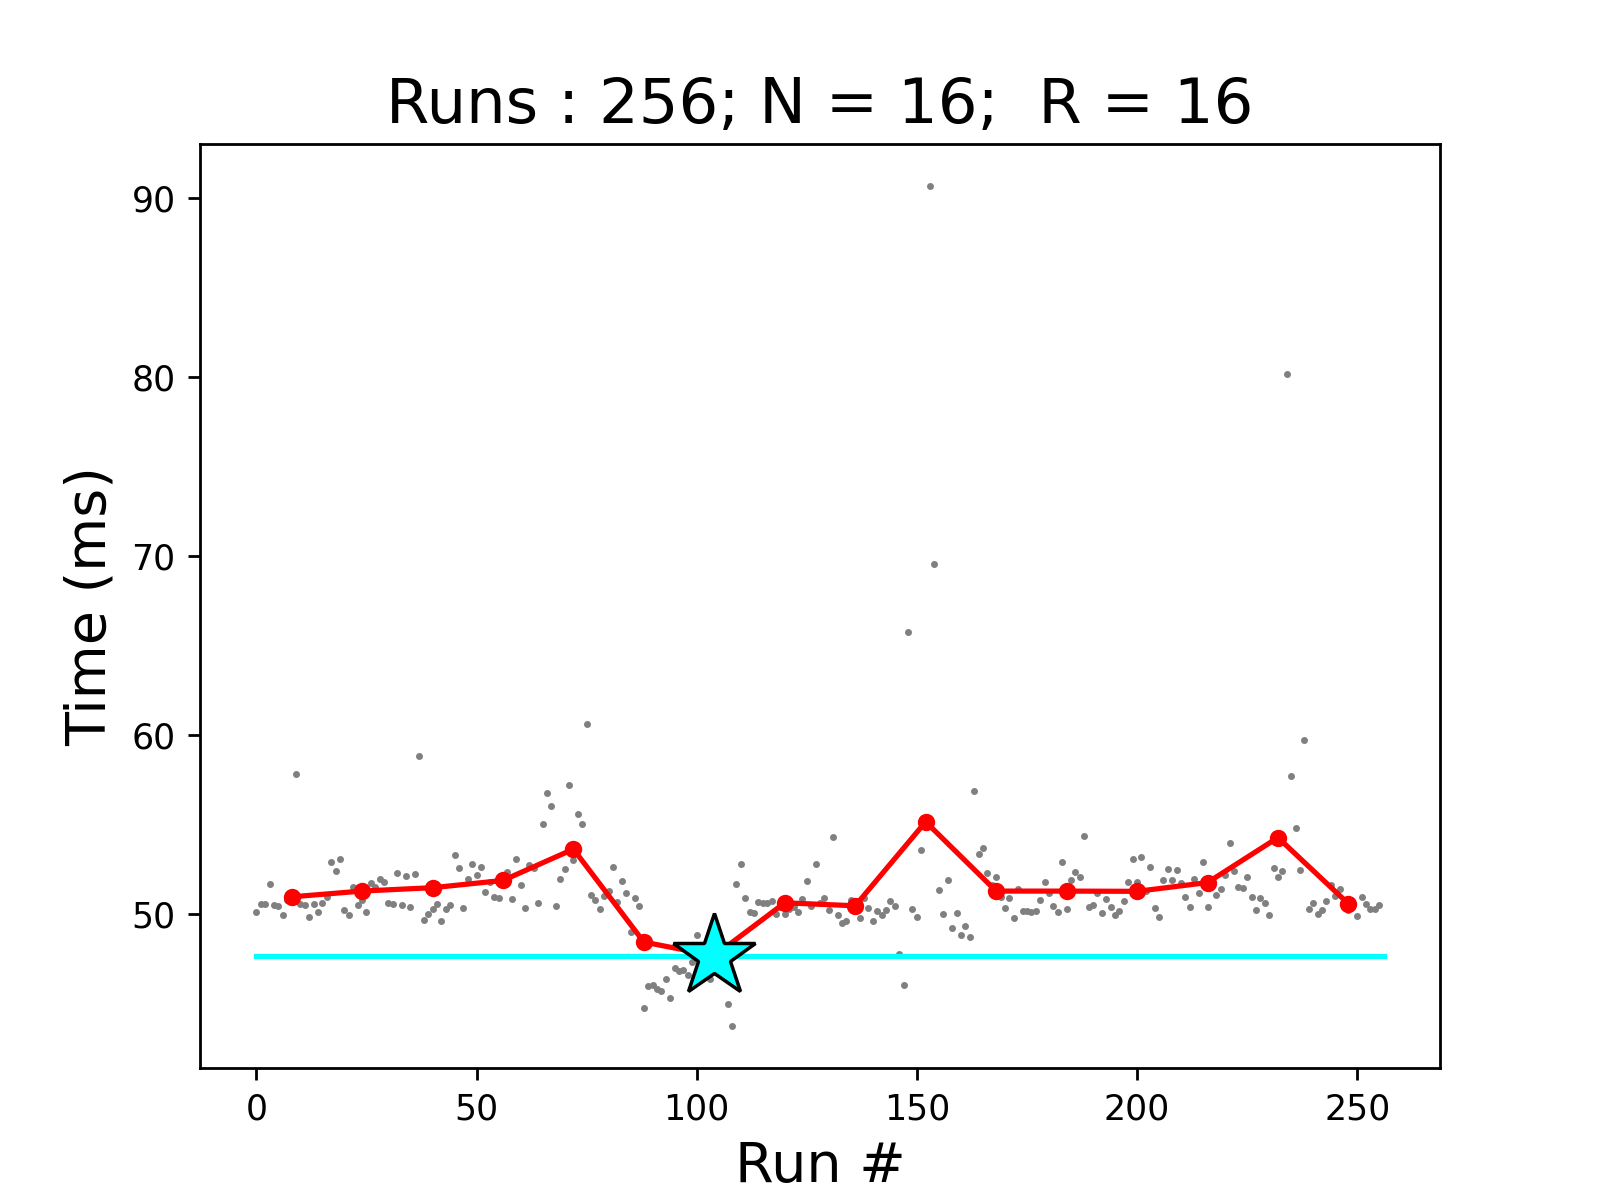

In [15]:
w = plot_window(t,m)

Using the slider below, you can simulate how the timing results would change if you vary `r` and `n`, (`r*n` is fixed).

In [16]:
display(w)

interactive(children=(IntSlider(value=4, description='p', max=8), Output()), _dom_classes=('widget-interact',)…

Finally, here is a comment on how to interpret timing statistics returned from Timeit.  This was taken from the `timeit` module [documentation](https://docs.python.org/3.7/library/timeit.html?highlight=timeit).

    It’s tempting to calculate mean and standard deviation from the result vector and report these. However, this is not very useful. In a typical case, the lowest value gives a lower bound for how fast your machine can run the given code snippet; higher values in the result vector are typically not caused by variability in Python’s speed, but by other processes interfering with your timing accuracy. So the min() of the result is probably the only number you should be interested in. After that, you should look at the entire vector and apply common sense rather than statistics.